# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, \
    floor, sort_array, asc, avg, concat, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Capstone") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load data and print information
df = spark.read.json("mini_sparkify_event_data.json")
df.printSchema()
df.summary().show(truncate=False, vertical=True)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------
 summary       | count                                                                                                              
 artist        | 228108                

In [4]:
# Check for blank userID and session IDs
print(df.select("userId").dropDuplicates().sort("userId").show())
print(df.select("sessionId").dropDuplicates().sort("sessionId").show())

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

None
+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows

None


In [5]:
#Investigate missing user and song information
print(df.filter(isnan(df["artist"])).groupby('page').count().show())
print(df.filter(isnan(df["firstName"])).groupby('page').count().show())

+----+-----+
|page|count|
+----+-----+
+----+-----+

None
+----+-----+
|page|count|
+----+-----+
+----+-----+

None


In [6]:
print("DF Rows Before Dropping NAs: {}".format(df.count()))

df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])
print("DF Rows After Dropping NAs: {}".format(df_valid.count()))

df_valid = df_valid.filter(df_valid["userId"] != "")
print("DF Rows After Removing Bad UserIDs: {}".format(df_valid.count()))

DF Rows Before Dropping NAs: 286500
DF Rows After Dropping NAs: 286500
DF Rows After Removing Bad UserIDs: 278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# Examine page distribution and count number of distinct users
print(df_valid.select("userId").dropDuplicates().summary().show())
print(df_valid.groupby('page').count().show())

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|               225|
|   mean|65391.013333333336|
| stddev|105396.47791907164|
|    min|                10|
|    25%|              60.0|
|    50%|             116.0|
|    75%|          100017.0|
|    max|                99|
+-------+------------------+

None
+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Up

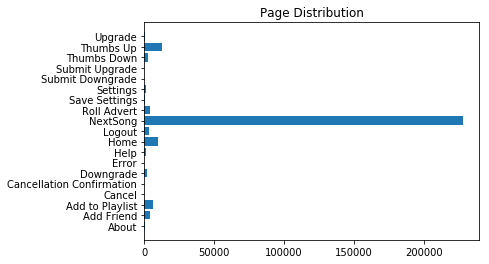

In [8]:
# Plot page distribution
df_valid_pd = df_valid.select(["page"]).toPandas()

counts = df_valid_pd["page"].value_counts().sort_values(ascending = True)

plt.barh(counts.index, counts)
  
plt.legend(loc='upper right')
plt.title('Page Distribution')
plt.show()

In [9]:
# Create cancellation effect flag (model target variable)
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_valid = df_valid.withColumn("Churn", flag_cancellation_event("page"))

In [10]:
# Create dummy variables for analysis and feature creation
#user activity flag - measures any time a user interacted with a song
flag_song_event = udf(lambda x: 1 if (x == "Add to Playlist" or x == "NextSong" or 
                      x == "Thumbs Up" or x == "Thumbs Down" or x == "Add Friend") else 0, IntegerType())
df_valid = df_valid.withColumn("ActivityInd", flag_song_event("page"))

#gender flag - male vs. female
flag_gender = udf(lambda x: 1 if (x == "M") else 0, IntegerType())
df_valid = df_valid.withColumn("MaleInd", flag_gender("gender"))

# paid flag - whether user was free or paid
flag_paid = udf(lambda x: 1 if (x == "paid") else 0, IntegerType())
df_valid = df_valid.withColumn("PaidInd", flag_paid("level"))

In [11]:
# Create date variables and calculate days since registration
gen_day_num = udf(lambda x: x/86400000)

df_valid = df_valid.withColumn("day_num", gen_day_num('ts'))
df_valid = df_valid.withColumn("day_num_floor", floor(df_valid.day_num))

df_valid = df_valid.withColumn("reg_day_num", gen_day_num('registration'))
df_valid = df_valid.withColumn("reg_day_num_floor", floor(df_valid.reg_day_num))

# Add one to days since registration to account for 0s
# Note - one negative value that needs to be changed to 1
df_valid = df_valid.withColumn("RegDays", df_valid.day_num_floor - df_valid.reg_day_num_floor + 1)
chg_neg_value = udf(lambda x: x if x > 0 else 1, IntegerType())
df_valid = df_valid.withColumn("RegDays", chg_neg_value(df_valid.RegDays))

In [12]:
# Create cumulative activity feature for all time
week_windowval = Window.partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)
df_valid = df_valid.withColumn("ActivitySum", Fsum("ActivityInd").over(week_windowval))

In [13]:
# Normalize activity by registration time. Fill in NAs 
df_valid = df_valid.withColumn("ActivitySumNorm", df_valid.ActivitySum/df_valid.RegDays)

In [14]:
# Sanity check derived variables
df_valid.select(['Churn', "ActivityInd", 'MaleInd', 'PaidInd', 'ActivitySum', 'RegDays', 'ActivitySumNorm']).summary().show()

+-------+--------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+
|summary|               Churn|        ActivityInd|            MaleInd|            PaidInd|       ActivitySum|          RegDays|   ActivitySumNorm|
+-------+--------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+
|  count|              278154|             278154|             278154|             278154|            278154|           278154|            278154|
|   mean|1.869467992550889E-4| 0.9131919727920504|0.44427187816820896| 0.7996757192059075|1221.1328436765245|65.77722772277228| 22.00432318026908|
| stddev|0.013671595449116166|0.28155404208758644| 0.4968855643484304|0.40024372479844644|1325.5124516640722|41.92013768625725|21.540533129356707|
|    min|                   0|                  0|                  0|                  0|                 0|         

In [15]:
# Examine target variable distribution between churn and non churn customers
df_valid.groupby("Churn").agg(count(col('userId')),  
                              avg(col("MaleInd")),
                              avg(col("PaidInd")),
                              avg(col("RegDays")),
                              avg(col("ActivitySum")),
                              avg(col("ActivitySumNorm"))).show()

+-----+-------------+-------------------+------------------+-----------------+------------------+--------------------+
|Churn|count(userId)|       avg(MaleInd)|      avg(PaidInd)|     avg(RegDays)|  avg(ActivitySum)|avg(ActivitySumNorm)|
+-----+-------------+-------------------+------------------+-----------------+------------------+--------------------+
|    1|           52| 0.6153846153846154|0.5961538461538461|58.36538461538461| 777.3653846153846|   16.49687924171174|
|    0|       278102|0.44423988320831925|0.7997137740828905| 65.7786136022035|1221.2158200947854|  22.005352971801713|
+-----+-------------+-------------------+------------------+-----------------+------------------+--------------------+



In [16]:
# Create pandas DF for visualization
df_valid_pd = df_valid.select(["Churn", "RegDays", "ActivitySumNorm"]).toPandas()
df_valid_pd.head()

,Churn,RegDays,ActivitySumNorm
0,0,12,0.083333
1,0,12,0.166667
2,0,12,0.250000
3,0,12,0.333333
4,0,12,0.416667


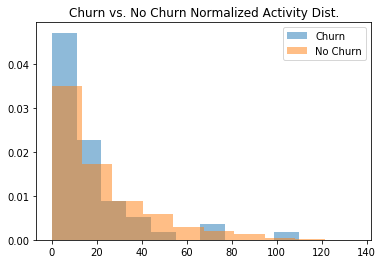

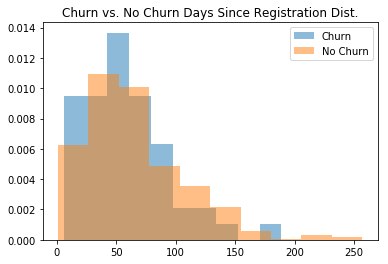

In [17]:
# Plot week activity distributions
# Week activity
plt.hist(df_valid_pd[df_valid_pd['Churn'] == 1]['ActivitySumNorm'], 
         density = True,
         alpha=0.5,
         label='Churn')
  
plt.hist(df_valid_pd[df_valid_pd['Churn'] == 0]['ActivitySumNorm'],
         density = True,
         alpha=0.5,
         label='No Churn')
  
plt.legend(loc='upper right')
plt.title('Churn vs. No Churn Normalized Activity Dist.')
plt.show()

# Normalized Week activity
plt.hist(df_valid_pd[df_valid_pd['Churn'] == 1]['RegDays'], 
         density = True,
         alpha=0.5,
         label='Churn')
  
plt.hist(df_valid_pd[df_valid_pd['Churn'] == 0]['RegDays'],
         density = True,
         alpha=0.5,
         label='No Churn')
  
plt.legend(loc='upper right')
plt.title('Churn vs. No Churn Days Since Registration Dist.')
plt.show()


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [18]:
# Create feature vectors
assembler = VectorAssembler(inputCols=["MaleInd", "PaidInd", "RegDays", "ActivitySumNorm"],outputCol="features")
df_valid = assembler.transform(df_valid)

In [19]:
# Create modeling dataset
data_model = df_valid.select(col("Churn").alias("label"), col("features"))
data_model.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.0,12.0,0.0...|
|    0|[0.0,0.0,12.0,0.1...|
|    0| [0.0,0.0,12.0,0.25]|
|    0|[0.0,0.0,12.0,0.3...|
|    0|[0.0,0.0,12.0,0.4...|
|    0|  [0.0,0.0,12.0,0.5]|
|    0|[0.0,0.0,12.0,0.5...|
|    0|[0.0,0.0,12.0,0.6...|
|    0|[0.0,0.0,12.0,0.6...|
|    0| [0.0,0.0,12.0,0.75]|
|    0|[0.0,0.0,12.0,0.8...|
|    0|[0.0,0.0,12.0,0.9...|
|    0|[0.0,0.0,12.0,0.9...|
|    0|  [0.0,0.0,12.0,1.0]|
|    0|[0.0,0.0,12.0,1.0...|
|    0|[0.0,0.0,12.0,1.1...|
|    0| [0.0,0.0,12.0,1.25]|
|    0| [0.0,0.0,12.0,1.25]|
|    0|[0.0,0.0,12.0,1.3...|
|    0|[0.0,0.0,12.0,1.3...|
+-----+--------------------+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [20]:
# Create train/test datasets
train, test = data_model.randomSplit((0.8, 0.2), seed = 42)

In [21]:
# Setup and train cross validated logistic regression model
lr = LogisticRegression()
lr_ParamGrid = ParamGridBuilder().addGrid(lr.elasticNetParam, [0, 0.5, 1]).build()
lr_crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = lr_ParamGrid,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 3)

# Train model and examine performance
LrCvModel = lr_crossval.fit(train)
print(LrCvModel.avgMetrics)

# Save best model and examine coefficients
best_lr_model = LrCvModel.bestModel
print(best_lr_model.coefficients)

[0.999750549279639, 0.999750549279639, 0.999750549279639]
[0.698121757003,-0.570338500725,-0.00508286094982,-6.91458966448e-05]


In [22]:
# Make out of sample predictions for analysis
lr_transformed = LrCvModel.transform(test)
lr_transformed = lr_transformed.withColumn("label",lr_transformed.label.cast(FloatType())).orderBy('prediction')
print(lr_transformed.show())

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[0.0,0.0,12.0,0.1...|[8.40143700365812...|[0.99977550598780...|       0.0|
|  0.0| [0.0,0.0,12.0,0.25]|[8.40144276581617...|[0.99977550728108...|       0.0|
|  0.0|[0.0,0.0,12.0,0.3...|[8.40144852797423...|[0.99977550857434...|       0.0|
|  0.0|  [0.0,0.0,12.0,1.0]|[8.40149462523866...|[0.99977551892022...|       0.0|
|  0.0| [0.0,0.0,12.0,1.25]|[8.40151191171282...|[0.99977552279980...|       0.0|
|  0.0|  [0.0,0.0,12.0,2.5]|[8.40159834408362...|[0.99977554219671...|       0.0|
|  0.0| [0.0,0.0,20.0,2.05]|[8.44223011602869...|[0.99978447758968...|       0.0|
|  0.0|  [0.0,0.0,20.0,2.1]|[8.44223357332352...|[0.99978447833465...|       0.0|
|  0.0|  [0.0,0.0,20.0,2.1]|[8.44223357332352...|[0.99978447833465...|       0.0|
|  0.0| [0.0,0.0

In [23]:
#Out of sample performance statistics
def out_of_sample_perf(test_df):
    """ Function to calculate out of sample performance statistics on test dataset
    
        Args:
            test_df: transformed dataset output from model
            
        Returns: 
            None
    
    """
    results = test_df.select(['prediction', 'label'])
    predictionAndLabels=results.rdd
    metrics = MulticlassMetrics(predictionAndLabels)

    cm=metrics.confusionMatrix().toArray()
    precision=metrics.precision()
    recall=metrics.recall()
    f_score = metrics.fMeasure()

    test_df.summary().show()
    print("Confusion Matrix: cm", cm)
    print("LogisticRegressionClassifier: precision,recall",precision,recall)
    print("LogisticRegressionClassifier F1 score: f_score", f_score)
    
    return None

In [24]:
print("Logistic Regression Out-of-Sample Statistics:")
out_of_sample_perf(lr_transformed)

Logistic Regression Out-of-Sample Statistics:
+-------+--------------------+----------+
|summary|               label|prediction|
+-------+--------------------+----------+
|  count|               55542|     55542|
|   mean|2.700658960786432E-4|       0.0|
| stddev|0.016431610439556033|       0.0|
|    min|                 0.0|       0.0|
|    25%|                 0.0|       0.0|
|    50%|                 0.0|       0.0|
|    75%|                 0.0|       0.0|
|    max|                 1.0|       0.0|
+-------+--------------------+----------+

Confusion Matrix: cm [[  5.55270000e+04   0.00000000e+00]
 [  1.50000000e+01   0.00000000e+00]]
LogisticRegressionClassifier: precision,recall 0.9997299341039213 0.9997299341039213
LogisticRegressionClassifier F1 score: f_score 0.9997299341039213


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.